## Use slide window to predict answers:

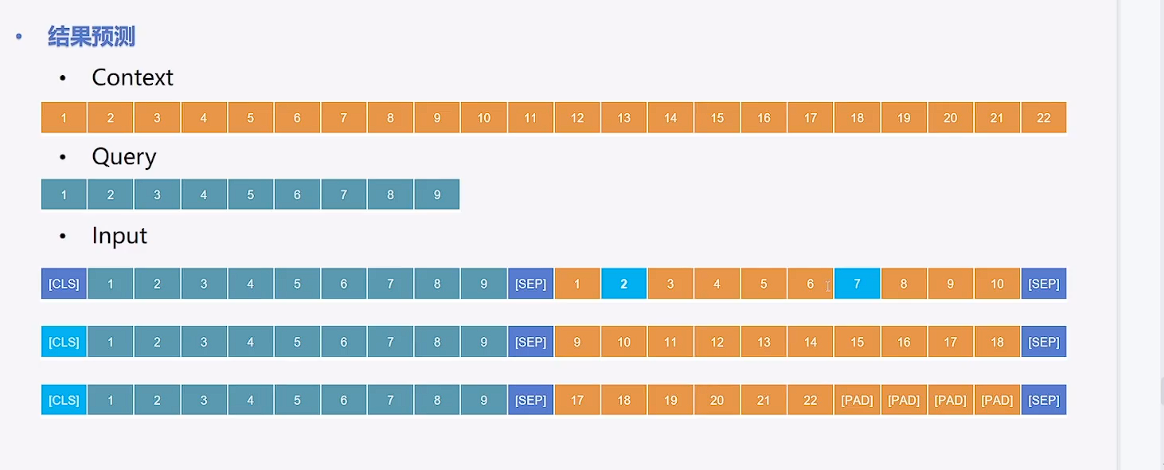

in the three slide windows, the 1st window predicts the 2 and 7 is the answer, and the 2nd and 3rd window predict the [CLS] is the answer means "no answer in this window"

In [1]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer, Pipeline, DefaultDataCollator
from datasets import *
import numpy as np
import evaluate
import collections
from cmrc_eval import *

In [2]:
data = DatasetDict.load_from_disk('./mrc_data')
print(data)
print(data['train'][0])
print(data['train'].features)

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 10142
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 3219
    })
    test: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1002
    })
})
{'id': 'TRAIN_186_QUERY_0', 'context': '范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机。1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，同年年底被擢升为枢机；2009年2月离世。范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南神父带到河内继续其学业。范廷颂于1940年在河内大修道院完成神学学业。范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务。1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民。1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范廷颂仍然留在河内。翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕。1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天主的爱」。由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作。范廷颂除了面对战争、贫困、被当局迫害天主教会等问题外，也秘密恢复修院、创建女修会团体等。1990年，教宗若望保禄二世在同年6月18日擢升范廷颂为天主教河内总教区宗座署理以填补该教区总主教的空缺。1994年3月23日，范廷颂被教宗若望保禄二世擢升为天主教河内总教区总主教并兼天主教谅山教区宗座署理；同年11月2

In [3]:
tokenizer = AutoTokenizer.from_pretrained("./macbert-base-chinese")
tokenizer

BertTokenizerFast(name_or_path='./macbert-base-chinese', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [55]:
sample = data['train'][:2]
tokenized_sample = tokenizer(text=sample['question'],
                             text_pair=sample['context'], 
                             return_offsets_mapping=True, # as the word_ids work
                             return_overflowing_tokens=True, # return slide windows for context
                             stride=128, # window steps
                             max_length=512,
                             truncation='only_second',
                             padding=True)

offset_mapping = tokenized_sample.pop("offset_mapping")
print(tokenized_sample)

{'input_ids': [[101, 5745, 2455, 7563, 3221, 784, 720, 3198, 952, 6158, 818, 711, 712, 3136, 4638, 8043, 102, 5745, 2455, 7563, 3364, 3322, 8020, 8024, 8021, 8024, 1760, 1399, 924, 4882, 185, 5735, 4449, 8020, 8021, 8024, 3221, 6632, 1298, 5384, 7716, 1921, 712, 3136, 3364, 3322, 511, 9155, 2399, 6158, 818, 711, 712, 3136, 8039, 8431, 2399, 6158, 3091, 1285, 711, 1921, 712, 3136, 3777, 1079, 2600, 3136, 1277, 2134, 2429, 5392, 4415, 8039, 8447, 2399, 6158, 3091, 1285, 711, 2600, 712, 3136, 8024, 1398, 2399, 2399, 2419, 6158, 3091, 1285, 711, 3364, 3322, 8039, 8170, 2399, 123, 3299, 4895, 686, 511, 5745, 2455, 7563, 754, 9915, 2399, 127, 3299, 8115, 3189, 1762, 6632, 1298, 2123, 2398, 4689, 1921, 712, 3136, 1355, 5683, 3136, 1277, 1139, 4495, 8039, 4997, 2399, 3198, 2970, 1358, 5679, 1962, 3136, 5509, 1400, 8024, 6158, 671, 855, 6632, 1298, 4868, 4266, 2372, 1168, 3777, 1079, 5326, 5330, 1071, 2110, 689, 511, 5745, 2455, 7563, 754, 9211, 2399, 1762, 3777, 1079, 1920, 934, 6887, 7368, 21

In [56]:
print(tokenized_sample.sequence_ids(0))

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [57]:
print(tokenized_sample.sequence_ids(1))

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [58]:
print(tokenized_sample.sequence_ids(2))

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [63]:
print(offset_mapping[0])

[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (

In [64]:
def process_func(example):
    tokenized_input = tokenizer(text=example['question'],
                       text_pair=example['context'], 
                       return_offsets_mapping=True, # as the word_ids work
                       return_overflowing_tokens=True, # return slide windows for context
                       stride=128, # window steps
                       max_length=512,
                       truncation='only_second',
                       padding='max_length')
    
    overflowing_mapping = tokenized_input.pop("overflow_to_sample_mapping")
    start_positions = []
    end_positions = []
    example_ids = []
    
    for idx, _ in enumerate(overflowing_mapping):
        answer = example['answers'][overflowing_mapping[idx]] # note the answer extraction!
        answer_start_ut = answer['answer_start'][0]
        answer_end_ut = answer_start_ut + len(answer['text'][0])

        context_start_t = tokenized_input.sequence_ids(idx).index(1)
        context_end_t = tokenized_input.sequence_ids(idx).index(None, context_start_t) - 1

        offset = tokenized_input.get("offset_mapping")[idx]

        if answer_start_ut > offset[context_end_t][1] or answer_end_ut < offset[context_start_t][0]: # fitler outside answer
            start_pos_token = 0
            end_pos_token = 0
        else:
            token_id = context_start_t
            while token_id <= context_end_t and offset[token_id][0] < answer_start_ut:
                token_id += 1
            start_pos_token = token_id
            token_id = context_end_t
            while token_id >= context_start_t and offset[token_id][1] > answer_end_ut:
                token_id -= 1
            end_pos_token = token_id
        start_positions.append(start_pos_token)
        end_positions.append(end_pos_token)
        example_ids.append(example['id'][overflowing_mapping[idx]])

        tokenized_input['offset_mapping'][idx] = [
            (v if tokenized_input.sequence_ids(idx)[k] == 1 else None) 
            for k, v in enumerate(tokenized_input['offset_mapping'][idx])
        ]
        
    tokenized_input['example_ids'] = example_ids
    tokenized_input["start_positions"] = start_positions
    tokenized_input["end_positions"] = end_positions

    return tokenized_input

In [65]:
tokenized_data = data.map(process_func, batched=True, remove_columns=data['train'].column_names)
print(tokenized_data)

Map:   0%|          | 0/10142 [00:00<?, ? examples/s]

Map:   0%|          | 0/3219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_ids', 'start_positions', 'end_positions'],
        num_rows: 14181
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_ids', 'start_positions', 'end_positions'],
        num_rows: 4570
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_ids', 'start_positions', 'end_positions'],
        num_rows: 1452
    })
})


In [69]:
print(tokenized_data['train'][0]['offset_mapping'])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, [0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [27, 28], [28, 29], [29, 30], [30, 34], [34, 35], [35, 36], [36, 37], [37, 38], [38, 39], [39, 40], [40, 41], [41, 45], [45, 46], [46, 47], [47, 48], [48, 49], [49, 50], [50, 51], [51, 52], [52, 53], [53, 54], [54, 55], [55, 56], [56, 57], [57, 58], [58, 59], [59, 60], [60, 61], [61, 62], [62, 63], [63, 67], [67, 68], [68, 69], [69, 70], [70, 71], [71, 72], [72, 73], [73, 74], [74, 75], [75, 76], [76, 77], [77, 78], [78, 79], [79, 80], [80, 81], [81, 82], [82, 83], [83, 84], [84, 85], [85, 86], [86, 87], [87, 91], [91, 92], [92, 93], [93, 94], [94, 95], [95, 96], [96, 97], [97, 98], [98, 99], [99, 100], [100, 101], [101, 105], [105, 106],

In [71]:
print(tokenized_data['train'][:20]['example_ids'])

['TRAIN_186_QUERY_0', 'TRAIN_186_QUERY_0', 'TRAIN_186_QUERY_1', 'TRAIN_186_QUERY_1', 'TRAIN_186_QUERY_2', 'TRAIN_186_QUERY_2', 'TRAIN_186_QUERY_3', 'TRAIN_186_QUERY_3', 'TRAIN_186_QUERY_4', 'TRAIN_186_QUERY_4', 'TRAIN_54_QUERY_0', 'TRAIN_54_QUERY_0', 'TRAIN_54_QUERY_1', 'TRAIN_54_QUERY_1', 'TRAIN_54_QUERY_2', 'TRAIN_54_QUERY_2', 'TRAIN_54_QUERY_3', 'TRAIN_54_QUERY_3', 'TRAIN_756_QUERY_0', 'TRAIN_756_QUERY_1']


In [68]:
sample = tokenized_data['train'][:20]['example_ids']
example_to_features = collections.defaultdict(list)
for idx, example_id in enumerate(sample):
    example_to_features[example_id].append(idx)
print(example_to_features)

defaultdict(<class 'list'>, {'TRAIN_186_QUERY_0': [0, 1], 'TRAIN_186_QUERY_1': [2, 3], 'TRAIN_186_QUERY_2': [4, 5], 'TRAIN_186_QUERY_3': [6, 7], 'TRAIN_186_QUERY_4': [8, 9], 'TRAIN_54_QUERY_0': [10, 11], 'TRAIN_54_QUERY_1': [12, 13], 'TRAIN_54_QUERY_2': [14, 15], 'TRAIN_54_QUERY_3': [16, 17], 'TRAIN_756_QUERY_0': [18], 'TRAIN_756_QUERY_1': [19]})


In [73]:
def get_model_result(start_logits, end_logits, example, tokenized_example):
    # define example_to_features dic
    # below will use dic to compute every example's every window's score and pick highest one
    example_to_features = collections.defaultdict(list)
    for idx, example_id in enumerate(example['example_ids']):
        example_to_features[example_id].append(idx)

    n_best_num = 20
    max_answer_length = 30
    predicrions = {}
    references = {}

    for example in example:
        example_id = example['id']
        context = example['context']
        answer = []
        for features_id in example_to_features[example_id]:
            start_logits = start_logits[features_id] # each window's logits
            end_logits = end_logits[features_id]
            start_indexes = np.argsort(start_logits)[::-1][:n_best_num].tolist()
            end_indexes = np.argsort(end_logits)[::-1][:n_best_num].tolist()
            offset = example['offset_mapping']
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if offset[start_index] == None or offset(end_index) == None:
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    answer.append(
                        {"text": context[offset[start_index]:offset[end_index]+1],
                        "score": start_logits[start_index] + end_logits[end_index]}
                    )
        if len(answer) > 0:
            best_answer = max(answer, lambda x: x["score"])
            predicrions[example_id] = best_answer['text']
        else:
            predictions[example_id] = ""
        references[example_id] = example['answers']['text']

    return predicrions, references

In [2]:
def compute_eval(pred):
    start_logits, end_logits = pred[0] # eval metric doesn't need labels(start pos), it compares "true sentence"
    if start_logits.shape[0] == len(data['validation']):
        p, r = get_result(start_logits, end_logits, data['validation'], tokenized_data['validation'])
    if start_logits.shape[0] == len(data['test']):
        p, r = get_result(start_logits, end_logits, data['test'], tokenized_data['test'])

    eval_result = evaluate_cmrc(p, r)

    return eval_result

In [4]:
mrc_model = AutoModelForQuestionAnswering.from_pretrained('./macbert-base-chinese')

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at ./macbert-base-chinese and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
train_arg = TrainingArguments(
            output_dir='./mrc_slide',
            save_strategy='epoch',
            save_total_limit=3,
            per_device_train_batch_size=32,
            per_device_eval_batch_size=64,
            learning_rate=2e-5,
            weight_decay=0.01,
            evaluation_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
)
train_arg

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=True,
group_by_length=False,
half_precision_backend=auto,
hub_always_push=False,
hub_mod

In [ ]:
trainer = Trainer(
        model = mrc_model,
        args=train_arg,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['test'],
        compute_metrics=compute_eval,
        data_collator=DefaultDataCollator,
)
trainer.train()